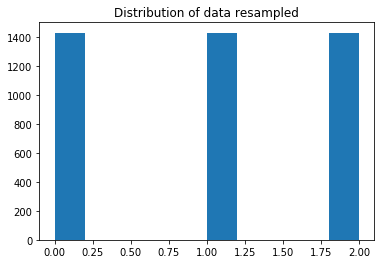

epoch =  1
Accuracy = 0.7826087, loss = 0.9757973
epoch =  2
Accuracy = 0.73913044, loss = 0.8186537
epoch =  3
Accuracy = 0.65217394, loss = 0.77483964
epoch =  4
Accuracy = 0.6956522, loss = 0.7242325
epoch =  5
Accuracy = 0.9130435, loss = 0.4506533
epoch =  6
Accuracy = 0.82608694, loss = 0.44147468
epoch =  7
Accuracy = 1.0, loss = 0.22742909


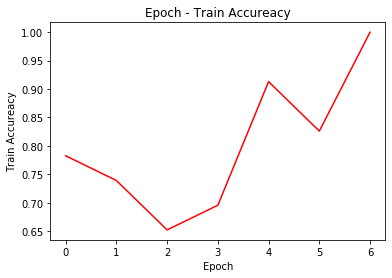

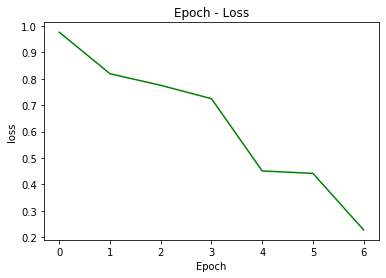

INFO:tensorflow:Restoring parameters from model.ckpt
Test_accuracy = 77.16%

confusion matrix will be: 
Predicted   0    1    2
Actual                 
0          90   35   22
1          19  109    8
2          10    4  132

classification report will be: 
              precision    recall  f1-score   support

           0       0.76      0.61      0.68       147
           1       0.74      0.80      0.77       136
           2       0.81      0.90      0.86       146

    accuracy                           0.77       429
   macro avg       0.77      0.77      0.77       429
weighted avg       0.77      0.77      0.77       429



In [13]:

# -*- coding: utf-8 -*-


import os
import numpy as np
import tensorflow as tf
from tensorflow.contrib import slim
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.metrics import classification_report
%matplotlib inline
tf.reset_default_graph()
class LSTM_CNN(object):
    def __init__(self,
                 num_classes,
                 seq_length,
                 vocab_size,
                 embedding_dim,
                 learning_rate,
                 learning_decay_rate,
                 learning_decay_steps,
                 epoch,
                 filter_sizes,
                 num_filters,
                 dropout_keep_prob,
                 l2_lambda,
                 lstm_dim
                 ):
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.learning_decay_rate = learning_decay_rate
        self.learning_decay_steps = learning_decay_steps
        self.epoch = epoch
        self.filter_sizes = filter_sizes
        self.num_filters = num_filters
        self.dropout_keep_prob = dropout_keep_prob
        self.l2_lambda = l2_lambda
        self.lstm_dim = lstm_dim
        self.input_x = tf.placeholder(tf.int32, [None, self.seq_length], name='input_x')
        self.input_y = tf.placeholder(tf.float32, [None, self.num_classes], name='input_y')
        self.l2_loss = tf.constant(0.0)
        self.model()
 
    def model(self):
        # embedding layer
        with tf.name_scope("embedding"):
            self.embedding = tf.Variable(tf.random_uniform([self.vocab_size, self.embedding_dim], -1.0, 1.0),
                                         name="embedding")
            self.embedding_inputs = tf.nn.embedding_lookup(self.embedding, self.input_x)
 
        # LSTM layer
        with tf.name_scope('lstm'):
            lstm = tf.contrib.rnn.LSTMCell(self.lstm_dim)
            lstm_cell = tf.contrib.rnn.MultiRNNCell([lstm])
            self.lstm_out, self.lstm_state = tf.nn.dynamic_rnn(lstm_cell, self.embedding_inputs, dtype=tf.float32)
            self.lstm_out_expanded = tf.expand_dims(self.lstm_out, -1)
 
        # conv layer + pooling layer
        pooled_outputs = []
        for i, filter_size in enumerate(self.filter_sizes):
            with tf.name_scope("conv_{0}".format(filter_size)):
                filter_shape = [filter_size, self.lstm_dim, 1, self.num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[self.num_filters]), name="b")
                conv = tf.nn.conv2d(self.lstm_out_expanded, W, strides=[1, 1, 1, 1], padding="VALID", name="conv")
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                pooled = tf.nn.max_pool(h, ksize=[1, self.seq_length - filter_size + 1, 1, 1], strides=[1, 1, 1, 1],
                                        padding='VALID', name="pool")
                pooled_outputs.append(pooled)
 
        # Concatenate the feature vectors which obtained from the each size's convolution kernels 
        num_filters_total = self.num_filters * len(self.filter_sizes)
        h_pool = tf.concat(pooled_outputs, 3)
        h_pool_flat = tf.reshape(h_pool, [-1, num_filters_total])
 
        # set up a dropout rate to final sentence vector  
        with tf.name_scope("dropout"):
            h_drop = tf.nn.dropout(h_pool_flat, self.dropout_keep_prob)
 
        # fully connected layer
        with tf.name_scope("output"):
            W = tf.get_variable("W", shape=[num_filters_total, self.num_classes],
                                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[self.num_classes]), name="b")
            self.l2_loss += tf.nn.l2_loss(W)
            self.l2_loss += tf.nn.l2_loss(b)
            self.logits = tf.nn.xw_plus_b(h_drop, W, b, name="scores")
            self.pred = tf.argmax(self.logits, 1, name="predictions")
 
        # loss function
        self.loss = tf.reduce_mean(
                                tf.nn.softmax_cross_entropy_with_logits(logits = self.logits,labels = self.input_y))+self.l2_lambda * self.l2_loss
 
        # optimization methods
        self.global_step = tf.train.get_or_create_global_step()
        learning_rate = tf.train.exponential_decay(self.learning_rate, self.global_step,
                                                   self.learning_decay_steps, self.learning_decay_rate,
                                                   staircase=True)
 
        optimizer = tf.train.AdamOptimizer(learning_rate)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        self.optim = slim.learning.create_train_op(total_loss=self.loss, optimizer=optimizer, update_ops=update_ops)
 
        # accuracy
        #self.acc = accuracy(logits=self.logits, labels=self.input_y)
        correct_pred = tf.equal(self.pred, tf.argmax(self.input_y,1))
        self.acc = tf.reduce_mean(tf.cast(correct_pred,tf.float32))
 
    def fit(self, train_x, train_y, batch_size):

        # start training
        train_steps = 0
  
        # initialize parameter
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        loss = []
        acc = []
        self.saver = tf.train.Saver()
        for i in range(self.epoch):
            batch_train = self.batch_iter(train_x, train_y, batch_size)
            for batch_x, batch_y in batch_train:
                train_steps += 1
                feed_dict = {self.input_x: batch_x, self.input_y: batch_y}
                _, train_loss, train_acc = sess.run([self.optim, self.loss, self.acc], feed_dict=feed_dict)
            loss.append(train_loss)
            acc.append(train_acc)
            print('epoch = ',i+1)
            print('Accuracy = %s, loss = %s'%(train_acc,train_loss))
            self.out_loss = loss
            self.out_acc = acc
            
            if train_acc >= 0.98:
                self.saver.save(sess,"model.ckpt")
                break
            
        sess.close()
 
    def batch_iter(self, x, y, batch_size = 32, shuffle=True):
      
        """
        generate batch data
        :param x: train set's feature
        :param y: train set's label 
        :param batch_size: the size of batch
        :param shuffle: Whether randomly shuffle the data at each epoch
        :return:
        """
        data_len = len(x)
        num_batch = int((data_len - 1) / batch_size) + 1
 
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_len))
            x_shuffle = x[shuffle_indices]
            y_shuffle = y[shuffle_indices]
        else:
            x_shuffle = x
            y_shuffle = y
        for i in range(num_batch):
            start_index = i * batch_size
            end_index = min((i + 1) * batch_size, data_len)
            yield (x_shuffle[start_index:end_index], y_shuffle[start_index:end_index])
 
    def predict(self, x,y):
        sess = tf.Session()
        #sess.run(tf.global_variables_initializer())
        self.saver.restore(sess,"model.ckpt")
        feed_dict = {self.input_x: x}
        logits = sess.run(self.logits, feed_dict=feed_dict)
        y_pred = np.argmax(logits, 1)
        correct_pred = tf.equal(y_pred, tf.argmax(y,1))
        test_acc = tf.reduce_mean(tf.cast(correct_pred,tf.float32))
        self.test_acc = sess.run(test_acc)
        sess.close()
        return y_pred

if __name__ == '__main__':
    #import and preprocessing data
    df = pd.read_csv("/content/labeled_data.csv")
    #df = pd.read_csv("labeled_data.csv")
    df.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'],axis=1,inplace=True)

    '''
    Here is our improved version of resampling solution below to solve the data unbalanced problem

    As we presented code before, it is not a balanced data
    
    But we have now solved it with a better accuracy performance,precision, recall and f1 measure.

    Especially for class 0 and class 2(which has much less data than class 1 before, but our new approach makes distribution of the data balanced)
    '''

    p_class0 = df[df['class'] == 0]
    p_class1 = df[df['class'] == 1]
    p_class2 = df[df['class'] == 2]
    #resample :Solve the problem of data imbalance
    re_class1 = resample(p_class1,replace = True,n_samples = len(p_class0),random_state=1)
    re_class2 = resample(p_class2,replace = True,n_samples = len(p_class0),random_state=1)
    re_sanpledata = pd.concat([p_class0,re_class1,re_class2])
    re_df = shuffle(re_sanpledata)

    X = re_df.tweet
    Y = re_df['class']
    plt.hist(Y)
    plt.title("Distribution of data resampled")
    plt.show()
    #pandas.core.series.Series
    
    #sklearn preprocessing, encode labels with value between 0 and (class_num - 1)
    le = LabelEncoder()
    #fit in label encoder and return labeled content
    Y = le.fit_transform(Y)

    # Y = [2 1 1 ... 1 1 2] np array
    Y = to_categorical(Y)
    #binary class matrix, in order to fit the training, [0, 1, 0], [1 , 0 , 0]
    Y = np.copy(Y.astype(np.int32))
    #convert it to np.int32 type, which change 1. to 1
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size= 0.1)
    max_words = 1000
    max_len = 260
    tok = Tokenizer(num_words=max_words)
    #remove punctuaton, convert text into sequence of words
    tok.fit_on_texts(X_train)
    #update internal vocabulary 

    #transform text in texts in a sequence of integers
    sequences = tok.texts_to_sequences(X_train)
    #training the data
    sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
    
    test_sequences = tok.texts_to_sequences(X_test)
    # testing the data
    test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
    
    #train
    #the main parameter is list below
    num_classes = 3
    seq_length = 260
    vocab_size = 1000
    embedding_dim = 100
    learning_rate = 0.005
    learning_decay_rate = 0.95
    learning_decay_steps = 100
    epoch = 100
    # 5 * 5
    filter_sizes = [5,5]
    num_filters = 32
    #randomly drop 50% final output weight to 0
    dropout_keep_prob = 0.8
    l2_lambda = 10
    lstm_dim = 10
    
    #ccreate CNN
    p = LSTM_CNN (num_classes,
                 seq_length,
                 vocab_size,
                 embedding_dim,
                 learning_rate,
                 learning_decay_rate,
                 learning_decay_steps,
                 epoch,
                 filter_sizes,
                 num_filters,
                 dropout_keep_prob,
                 l2_lambda,
                 lstm_dim
                 )
    #sequences_matrix.shape[0]
    p.fit(sequences_matrix,Y_train,batch_size = sequences_matrix.shape[0] // 100)
    
    
    L = list(range(len(p.out_acc))) 
    plt.plot(L,p.out_acc,'r')
    plt.title('Epoch - Train Accureacy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accureacy')
    plt.show()
    
    plt.plot(L,p.out_loss,'g')
    plt.title('Epoch - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.show()
    
    # Generate evaluation: the accuracy, confusion matrix, recall, precision and f1-score,etc
    actualResult = [ list(i).index(1) for i in Y_test]
    p.dropout_keep_prob = 1
    predictResult = p.predict(x =test_sequences_matrix,y = Y_test)
    #predictResult = p.predict(x =sequences_matrix,y = Y_train)
    data = {"y_predicted": predictResult, "y_actual": actualResult}

    df = pd.DataFrame(data, columns=['y_actual','y_predicted'])

    confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'])


    print('Test_accuracy = %.2f' % (p.test_acc * 100), '%' ,sep='')

    print()

    print("confusion matrix will be: ")


    print(confusion_matrix)
    print()
    
    print("classification report will be: ")

    print(classification_report(actualResult, predictResult))
    
    

    
    
    
    

    

In [0]:
predictResult = p.predict(x =sequences_matrix,y = Y_train)
print(p.test_acc)

NameError: ignored